# Pseudotime for GAMM pig retinal organoid sample 1 (day 40)

## First we use palantir to construct a pseudo time

In [1]:
# Palantir
# source venv/bin/activate
# load packages

import palantir
import scanpy as sc
import pandas as pd
import os

# Plotting
import matplotlib
import matplotlib.pyplot as plt

# warnings
import warnings
from numba.core.errors import NumbaDeprecationWarning

warnings.filterwarnings(action="ignore", category=NumbaDeprecationWarning)
warnings.filterwarnings(
    action="ignore", module="scanpy", message="No data for colormapping"
)

# Inline plotting
%matplotlib inline

# variables
DATA_DIR = "/w5home/bmoore/scRNAseq/GAMM/GAMM_S1/output_20230921_142919/" 
ADATA_FILE = "GAMM_S1_clabeled-clusters_0.5.h5ad" 
ANNOT_TYPE = "manual" # "seurat_map", "clustifyr", "manual", "orig.ident"
CROSS_SPECIES = "FALSE" # "TRUE" or "FALSE"
NC = 10 # number of components

In [2]:
# load data
## note- data was previously converted from seurat object to anndata object

data_dir = os.path.expanduser(DATA_DIR)
adata = sc.read_h5ad(data_dir + ADATA_FILE)
adata
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y%m%d_%H%M%S")
out_dir = data_dir + "pseudotime_" + now +"/"
os.mkdir(out_dir)

/w5home/bmoore/Gamm_scRNAseq/src/pst_env/lib/python3.11/site-packages/anndata/compat/__init__.py:298: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [3]:
# check metadata

# check indices
adata_top = adata.obs.head()
list(adata_top.index)
# read in metadata
# metadata = pd.read_csv(data_dir + "gamm_manual_annot_metadata_c0.5.txt", index_col=0, sep="\t")
# #print(metadata.head())
# print(len(metadata))
# metadata = metadata.drop_duplicates()
# print(len(metadata))
# # add metadata
# adata.obs['CellType'] = metadata['CellType']
# check if added
print(adata.obs['CellType_manual'].unique())

['Retinal Prog' 'Cones' 'Ganglion Cells' 'unknown']


In [4]:
# Run diffusion maps
dm_res = palantir.utils.run_diffusion_maps(adata, n_components=NC)
ms_data = palantir.utils.determine_multiscale_space(adata)

/w5home/bmoore/Gamm_scRNAseq/src/pst_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


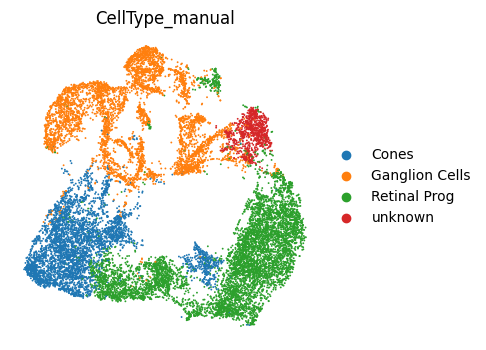

AnnData object with n_obs × n_vars = 16654 × 31781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'percent.mt', 'sizeFactors', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.5', 'seurat_clusters', 'CellType', 'CellType_manual'
    var: 'features'
    uns: 'neighbors', 'DM_EigenValues', 'CellType_manual_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'DM_EigenVectors', 'DM_EigenVectors_multiscaled'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances', 'DM_Kernel', 'DM_Similarity'

In [5]:
# visualize (note we have already done nearest neighbor and umap)
sc.pl.embedding(
    adata,
    basis="umap",
    frameon=False,
    color='CellType_manual',
)
adata

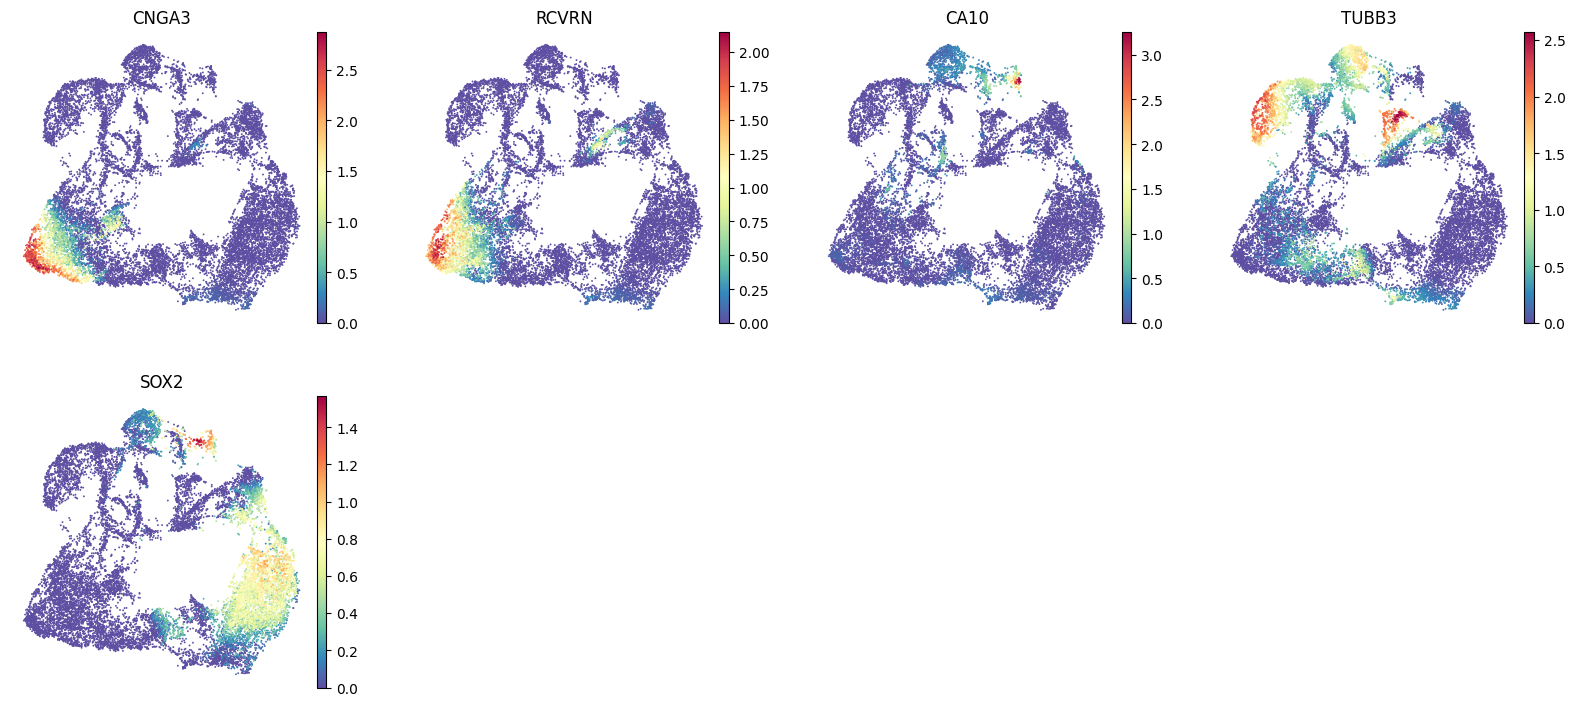

In [33]:
# MAGIC imputation
# Palantir uses MAGIC to impute the data for visualization and determining gene expression trends.
imputed_X = palantir.utils.run_magic_imputation(adata)
# gene expression visualization on UMAP
if CROSS_SPECIES == "FALSE":
    if ANNOT_TYPE == "orig.ident":
        genes = ["MIXL1","HES1","HES5","HES7","LFNG","DLL1","MSGN1"]
    else:
        genes = ["CNGA3","RCVRN", "CA10", "TUBB3","SOX2"]
else:
    genes = ["CNGA3", "RCVRN", "CA10"]


with plt.rc_context():
    sc.pl.embedding(
    adata,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=genes,
    frameon=False,
    show=False,
    )
    plt.savefig(out_dir + "gene_expression.png")
#plt.show()

In [7]:
print(adata.obs.columns, adata.var['features'][1:10], adata.var_names[1:10])
print(adata.obs['CellType_manual'].unique(), adata.obs['old.ident'].unique())

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident',
       'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted',
       'scDblFinder.cxds_score', 'percent.mt', 'sizeFactors', 'S.Score',
       'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.5', 'seurat_clusters',
       'CellType', 'CellType_manual'],
      dtype='object') ANXA1                              ANXA1
RORB                                RORB
TRPM6                              TRPM6
C9orf40                          C9orf40
CARNMT1                          CARNMT1
NMRK1                              NMRK1
OSTF1                              OSTF1
ENSSSCG00000045514    ENSSSCG00000045514
PCSK5                              PCSK5
Name: features, dtype: object Index(['ANXA1', 'RORB', 'TRPM6', 'C9orf40', 'CARNMT1', 'NMRK1', 'OSTF1',
       'ENSSSCG00000045514', 'PCSK5'],
      dtype='object')
['Retinal Prog', 'Cones', 'Ganglion Cells', 'unknown']
Categories (4, object): ['Cones', 'Ganglion Cells', 'Retinal Prog

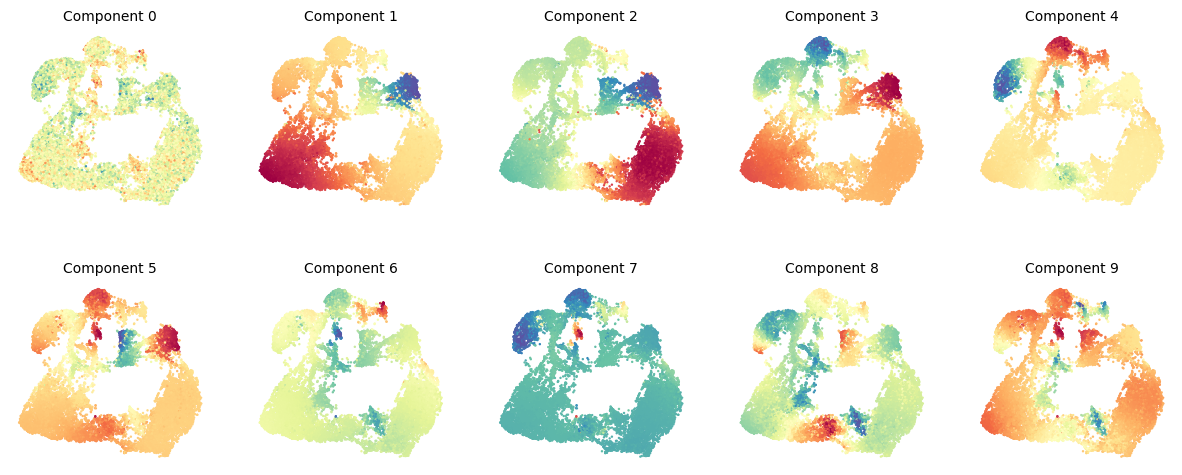

In [11]:
# Diffusion maps visualization
palantir.plot.plot_diffusion_components(adata)
plt.savefig(out_dir + 'palantir_components_umap.png')
plt.show()

In [12]:
# find terminal states

if ANNOT_TYPE == "clustifyr":
    # clustifyr
    set(adata.obs['clustifyr_call_consol_type'])
    terminal_states = palantir.utils.find_terminal_states(adata,celltypes=["Pan PRs","Cones","Bipolar Cells", "Muller Glia"],celltype_column="clustifyr_call_consol_type")
elif ANNOT_TYPE == "manual":
    # manual annotation
    set(adata.obs['CellType_manual'])
    terminal_states = palantir.utils.find_terminal_states(adata,celltypes=['Cones', 'Ganglion Cells'],celltype_column="CellType_manual")
elif ANNOT_TYPE == "seurat_map":
    # seurat mapping annotation
    set(adata.obs['predicted.celltype'])
    terminal_states = palantir.utils.find_terminal_states(adata,celltypes=["AC","BC","HC", "PR","RGC","iMG"],celltype_column="predicted.celltype")
elif ANNOT_TYPE == "orig.ident":
    # timepoint/original annotation
    set(adata.obs['orig.ident'])
    terminal_states = palantir.utils.find_terminal_states(adata,celltypes=["ResyncTime6","ResyncTime5"],celltype_column="orig.ident")
else:
    print("Error: invalid annotation type")

Using TTTGGTTGTTTCCAAG_1 for cell type Cones which is max in diffusion component 0.
Using GCCTGTTGTAACGGTG_1 for cell type Ganglion Cells which is min in diffusion component 2.


In [13]:
#set(adata.obs['predicted.celltype'])
#terminal_states=[terminal_state1,terminal_state2]
print(terminal_states)

TTTGGTTGTTTCCAAG_1             Cones
GCCTGTTGTAACGGTG_1    Ganglion Cells
dtype: object


In [14]:
# find start cell

if ANNOT_TYPE == "clustifyr":
    # clustifyr
    # use Retinal Prog to find start cell
    start_cell = palantir.utils.early_cell(adata,celltype="Retinal Prog",celltype_column="clustifyr_call_consol_type",fallback_seed=1234)
elif ANNOT_TYPE == "manual":
    # manual annotation
    # use Retinal Progenitor-Muller Glia to find start cell
    start_cell = palantir.utils.early_cell(adata,celltype="Retinal Prog",celltype_column="CellType_manual",fallback_seed=1234)
elif ANNOT_TYPE == "seurat_map":
    # seurat mapping
    start_cell = palantir.utils.early_cell(adata,celltype="Prog",celltype_column="predicted.celltype",fallback_seed=1234)
elif ANNOT_TYPE == "orig.ident":
    # timepoint/original annotation
    start_cell = palantir.utils.early_cell(adata,celltype="ResyncTime1",celltype_column="orig.ident",fallback_seed=1234)
else:
    print("Error: invalid annotation type")

Using CAATCGATCTGGCCAG_1 for cell type Retinal Prog which is max in diffusion component 1.


Sampling and flocking waypoints...
Time for determining waypoints: 0.015842286745707194 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 1.825221053759257 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9995
Correlation at iteration 2: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


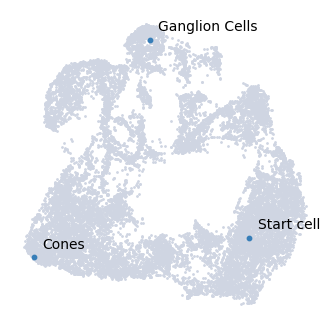

TTTGGTTGTTTCCAAG_1             Cones
GCCTGTTGTAACGGTG_1    Ganglion Cells
CAATCGATCTGGCCAG_1        Start cell
dtype: object


In [15]:
# use cells found for start cell and terminal states for palantir analysis

# Run Palantir
if len(terminal_states) == 0:
    lista = [start_cell]
    pr_res = palantir.core.run_palantir(adata, start_cell, num_waypoints=500, use_early_cell_as_start=True)
    # plot with start cell
    palantir.plot.highlight_cells_on_umap(adata, lista)
    plt.savefig(out_dir + 'palantir_start_cell.png')
    plt.show()
else:
    pr_res = palantir.core.run_palantir(
    adata, start_cell, num_waypoints=500, terminal_states=terminal_states
    )
    # plot with terminal cells and start cell
    all_cells = terminal_states.copy()
    all_cells[start_cell] = "Start cell"
    palantir.plot.highlight_cells_on_umap(adata, all_cells)
    plt.savefig(out_dir + 'palantir_terminal_cells.png')
    plt.show()
    print(all_cells)


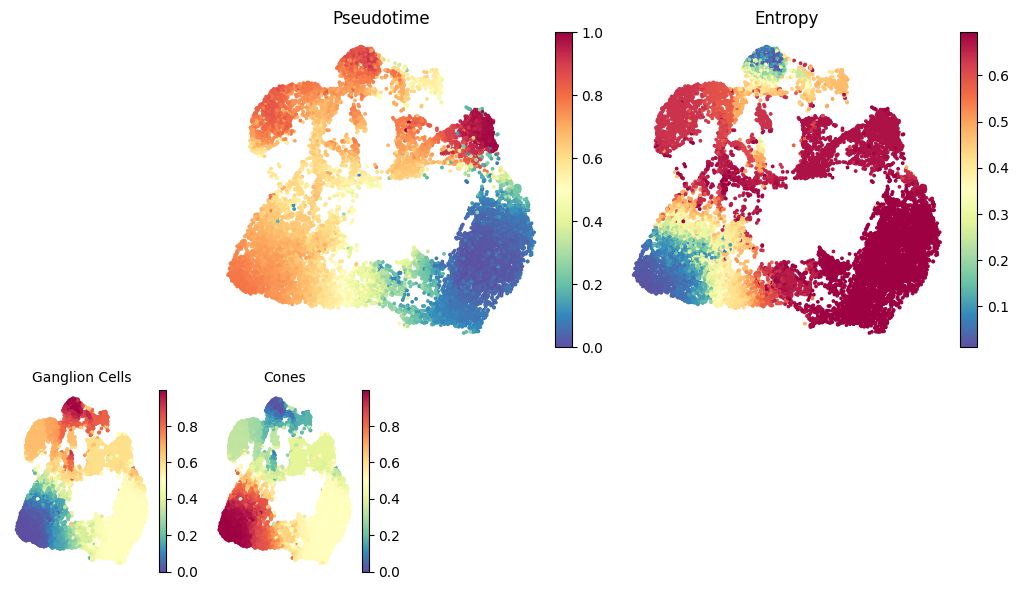

In [16]:
# plot results
palantir.plot.plot_palantir_results(adata, s=3)
plt.savefig(out_dir + 'palantir_results.png')
plt.show()

Index(['TTTGGTTGTTTCCAAG_1', 'GCCTGTTGTAACGGTG_1', 'CAATCGATCTGGCCAG_1'], dtype='object')


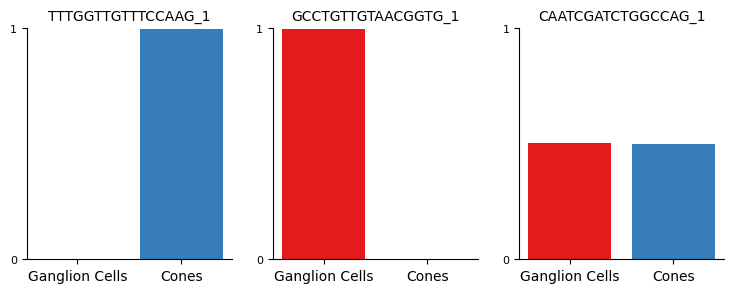

In [17]:
# Terminal state probability distributions of individual cells can be visualized using the plot_terminal_state_probs function

if len(terminal_states) == 0:
    lista = [start_cell]
    palantir.plot.plot_terminal_state_probs(adata, lista)
    plt.savefig(out_dir + 'terminal_state_probs.png')
    plt.show()
else:
    cells=all_cells.index
    print(cells)
    palantir.plot.plot_terminal_state_probs(adata, cells)
    plt.savefig(out_dir + 'terminal_state_probs.png')
    plt.show()

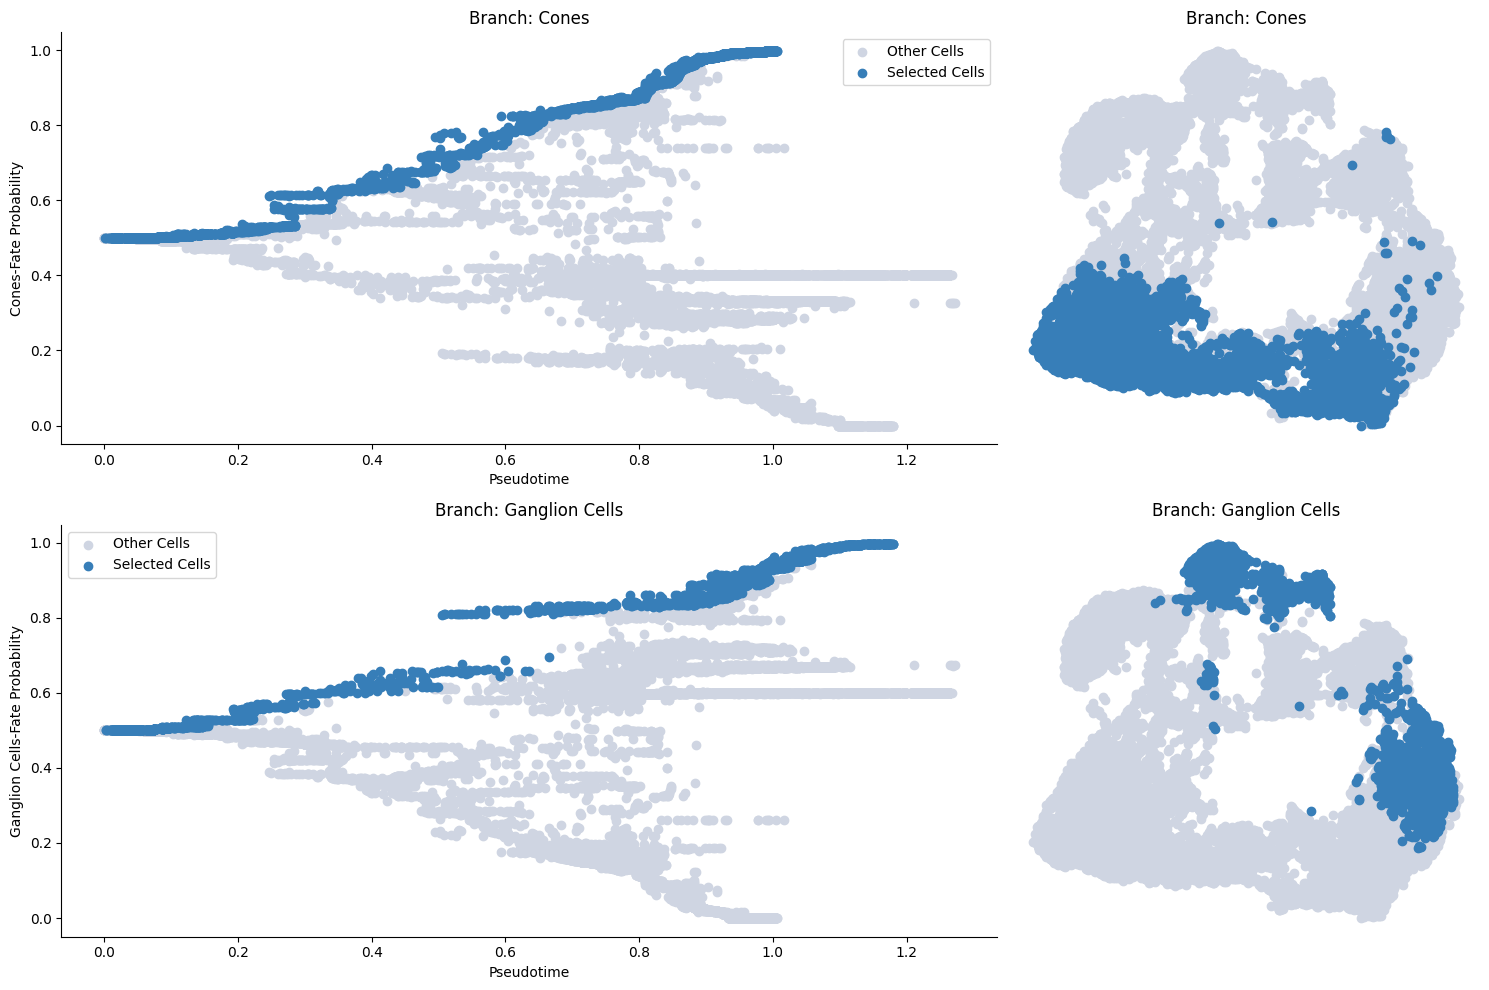

In [18]:
# Branch probabilities

# Select cells
# Before computing the gene expression trends, we first need to select cells associated with a specific branch of the pseudotime trajectory.
masks = palantir.presults.select_branch_cells(adata, eps=0)
# visualize the branck selection
palantir.plot.plot_branch_selection(adata)
plt.savefig(out_dir + 'branch_selection.png')
plt.show()

In [19]:
gene_trends = palantir.presults.compute_gene_trends(
    adata, expression_key="MAGIC_imputed_data",)
print(adata)
#gene_trend_key

Ganglion Cells
[2024-01-30 12:45:47,239] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (2,329) and rank = 1.0.
[2024-01-30 12:45:47,241] [INFO    ] Using covariance function Matern52(ls=1.0).
Cones
[2024-01-30 12:45:55,644] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (5,085) and rank = 1.0.
[2024-01-30 12:45:55,646] [INFO    ] Using covariance function Matern52(ls=1.0).
AnnData object with n_obs × n_vars = 16654 × 31781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ident', 'scDblFinder.class', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'percent.mt', 'sizeFactors', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.5', 'seurat_clusters', 'CellType', 'CellType_manual', 'palantir_pseudotime', 'palantir_entropy'
    var: 'features'
    uns: 'neighbors', 'DM_EigenValues', 'CellType_manual_colors', 'palantir_waypoints'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'DM_EigenVectors', 'DM_

Ganglion Cells
[2024-01-30 12:46:21,150] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (2,329) and rank = 1.0.
[2024-01-30 12:46:21,152] [INFO    ] Using covariance function Matern52(ls=1.0).
Cones
[2024-01-30 12:46:25,846] [INFO    ] Using sparse Gaussian Process since n_landmarks (500) < n_samples (5,085) and rank = 1.0.
[2024-01-30 12:46:25,847] [INFO    ] Using covariance function Matern52(ls=1.0).


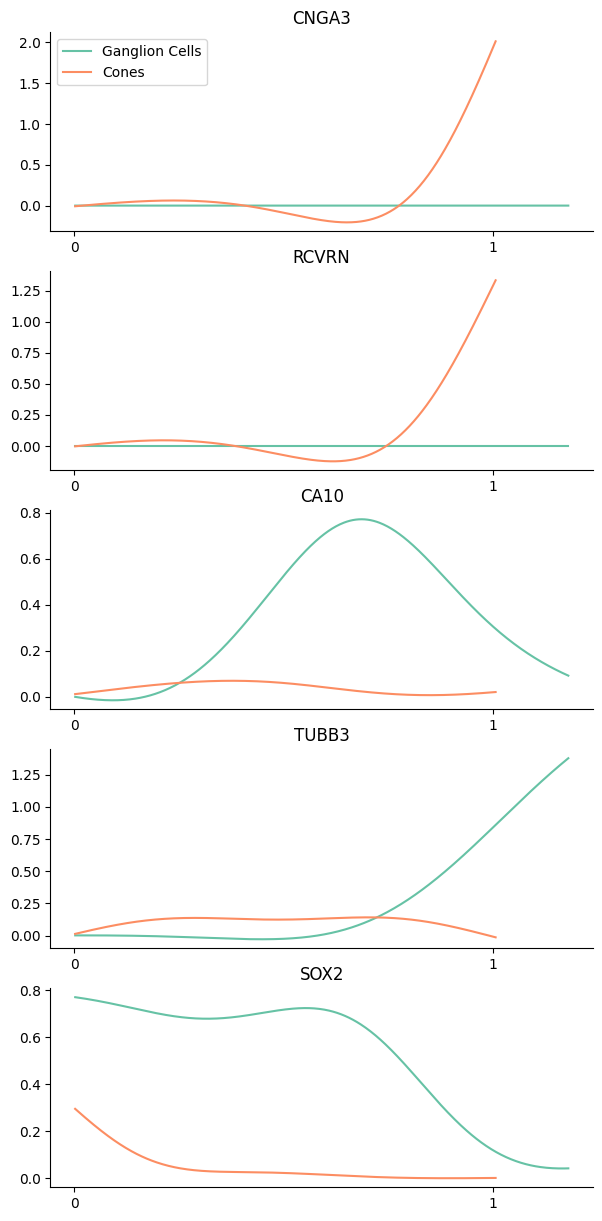

In [20]:
# Determine marker gene trends using the  Mellon Function Estimator
gene_trends = palantir.presults.compute_gene_trends(
    adata,
    expression_key="MAGIC_imputed_data",
)
# visualize trends
if CROSS_SPECIES == "FALSE":
    if ANNOT_TYPE == "orig.ident":
        genes = ["MIXL1","HES1","HES5","HES7","LFNG","DLL1","MSGN1"]
        palantir.plot.plot_gene_trends(adata, genes)
        plt.savefig(out_dir + 'gene_trends.png')
        plt.show()
        
    else:
        genes = ["CNGA3", "RCVRN","CA10", "TUBB3","SOX2"]
        palantir.plot.plot_gene_trends(adata, genes)
        plt.savefig(out_dir + 'gene_trends.png')
        plt.show()
else:
    genes = ["CNGA3", "RCVRN", "CA10"]
    palantir.plot.plot_gene_trends(adata, genes)
    plt.savefig(out_dir + 'gene_trends.png')
    plt.show()
    


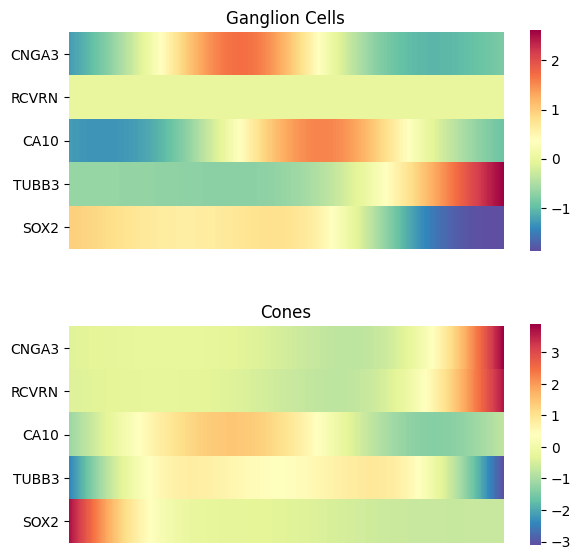

In [21]:
# Heatmap trend visualization
palantir.plot.plot_gene_trend_heatmaps(adata, genes)
plt.savefig(out_dir + 'gene_trends_heatmap.png')
plt.show()

/w5home/bmoore/Gamm_scRNAseq/src/pst_env/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


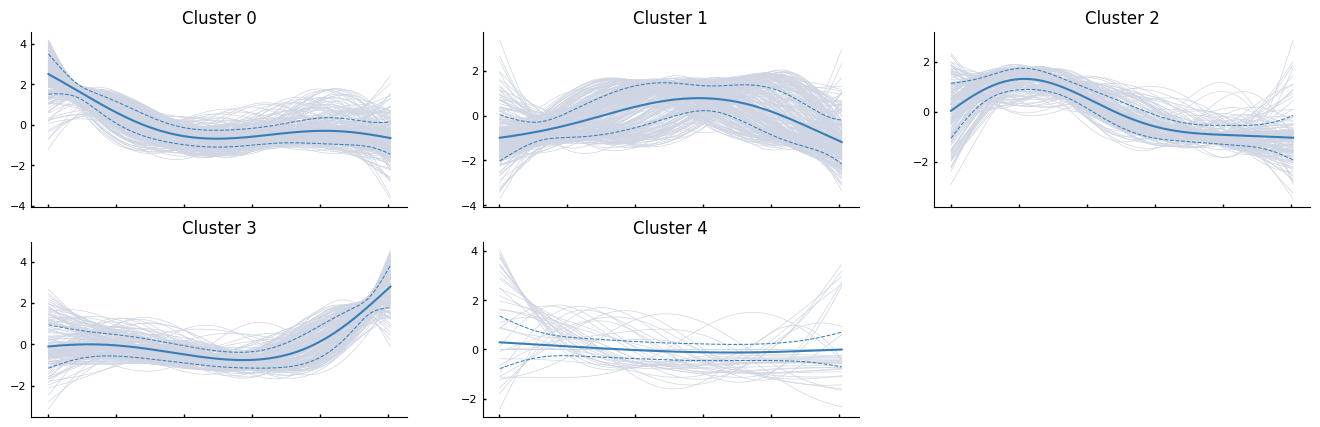

In [22]:
# Clustering
# Gene expression trends can be clustered and visualized
# Here the first 1000 genes along the cones genes are clustered
more_genes = adata.var_names[:1000]
if ANNOT_TYPE == "clustifyr":
    # clustifyr
    communities = palantir.presults.cluster_gene_trends(adata, "Cones", more_genes)
    palantir.plot.plot_gene_trend_clusters(adata, "Cones")
elif ANNOT_TYPE == "manual":
    # manual annotation
    communities = palantir.presults.cluster_gene_trends(adata, 'Cones', more_genes)
    palantir.plot.plot_gene_trend_clusters(adata, 'Cones')
elif ANNOT_TYPE == "seurat_map":
    # seurat mapping
    communities = palantir.presults.cluster_gene_trends(adata, "PR", more_genes)
    palantir.plot.plot_gene_trend_clusters(adata, "PR")
elif ANNOT_TYPE == "orig.ident":
    # timepoint/original annotation
    communities = palantir.presults.cluster_gene_trends(adata, "ResyncTime5", more_genes)
    palantir.plot.plot_gene_trend_clusters(adata, "ResyncTime5")
else:
    print("Error: invalid annotation type")
# save figure and show
plt.savefig(out_dir + 'gene_trend_clusters.png')
plt.show()

In [23]:
adata
# weird seurat to anndata thing- anndata doesn not like a column named _index
adata.__dict__['_raw'].__dict__['_var'] = adata.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [24]:
import numpy as np
import cellrank as cr
import scanpy as sc
import scvelo as scv
# compute diffusion pseudotime (DPT)
# start by computing a diffusion map
# need to recompute nearest neighbots first
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
sc.tl.diffmap(adata)

In [25]:
# find root cell
root_ixs = adata.obsm['X_diffmap'][:, 3].argmax()
print(root_ixs)

12739


saving figure to file /w5home/bmoore/scRNAseq/GAMM/GAMM_S1/output_20230921_142919/pseudotime_20240130_122716/diffusion_map.png


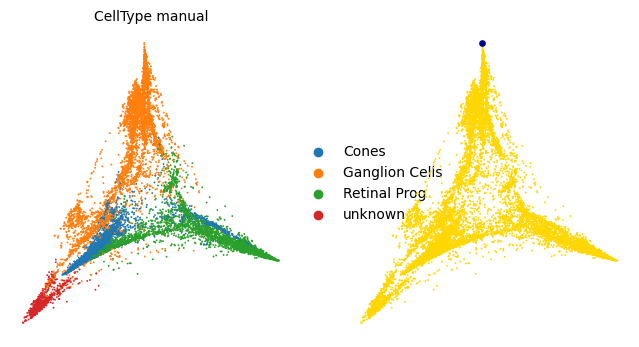

In [27]:
# visualize and set root

if ANNOT_TYPE == "clustifyr":
    scv.pl.scatter(
    adata,
    basis="diffmap",
    c=['clustifyr_call_consol_type', root_ixs],
    legend_loc="right",
    components=["2, 3"],
    save= out_dir +'diffusion_map.png'
    )
    
elif ANNOT_TYPE == "manual":
    scv.pl.scatter(
    adata,
    basis="diffmap",
    c=['CellType_manual', root_ixs],
    legend_loc="right",
    components=["2, 3"],
    save= out_dir +'diffusion_map.png'
    )
    
elif ANNOT_TYPE == "seurat_map":
    scv.pl.scatter(
        adata,
        basis="diffmap",
        c=['predicted.celltype', root_ixs],
        legend_loc="right",
        components=["2, 3"],
        save= out_dir +'diffusion_map.png'
    )
elif ANNOT_TYPE == "orig.ident":
    scv.pl.scatter(
        adata,
        basis="diffmap",
        c=['orig.ident', 62], 
        legend_loc="right",
        components=["2, 3"],
        save= out_dir +'diffusion_map.png'
    )
    
adata.uns["iroot"] = root_ixs

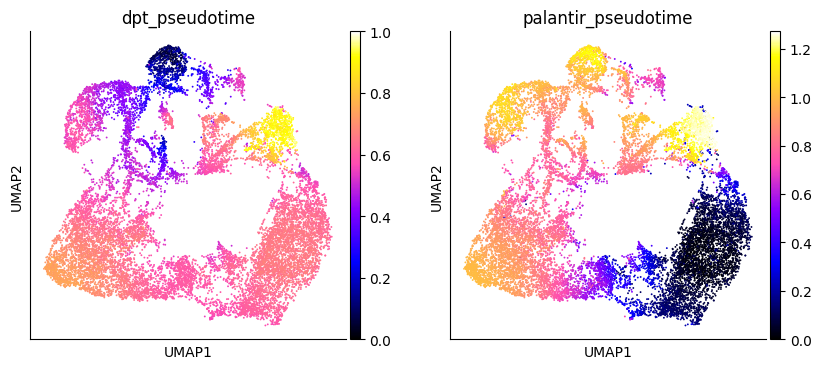

In [28]:
# Compute DPT and compare it with the precomputed Palantir pseudotime:
sc.tl.dpt(adata)
with plt.rc_context():
    sc.pl.embedding(
    adata,
    basis="umap",
    color=["dpt_pseudotime", "palantir_pseudotime"],
    color_map="gnuplot2",
    show=False
    )
    plt.savefig(out_dir +'dpt-palantir_pseudotime.png')

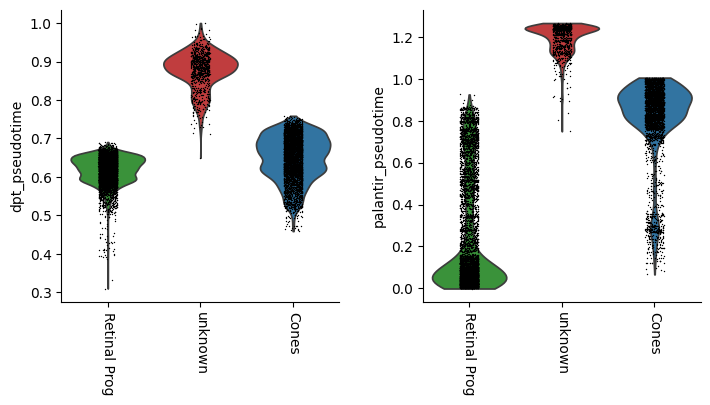

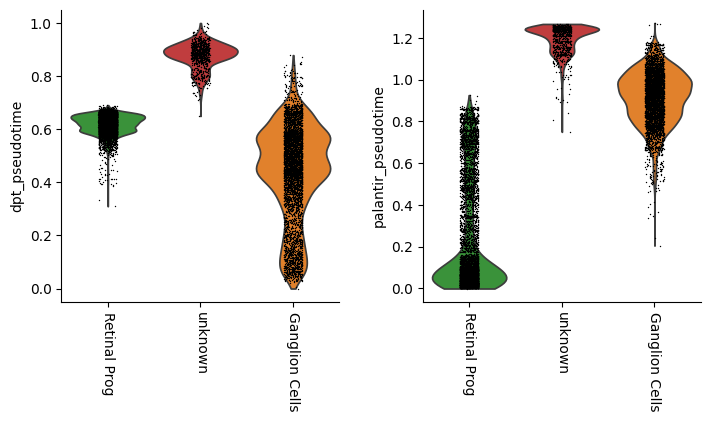

In [29]:
# plot trajectory
cone_trajectory = "NA"
bipolar_trajectory = "NA"
rod_trajectory = "NA"
pr_trajectory = "NA"
img_trajectory = "NA"
ac_trajectory = "NA"
time_trajectory = "NA"
ganglion_trajectory = "NA"
mg_trajectory = "NA"

if ANNOT_TYPE == "clustifyr":
    cone_trajectory = ["Retinal Prog", "Pan PRs", "Cones"]
    bipolar_trajectory = ["Retinal Prog", "Muller Glia", "Bipolar Cells"]
    rod_trajectory = ["Retinal Prog", "Pan PRs"]
    key= "clustifyr_call_consol_type"
elif ANNOT_TYPE == "manual":
    cone_trajectory = ['Retinal Prog', 'unknown', 'Cones']
    ganglion_trajectory = ['Retinal Prog', 'unknown', 'Ganglion Cells']
    key= "CellType_manual"
elif ANNOT_TYPE == "seurat_map":
    pr_trajectory = ["Prog","Prog/Glia","PR"]
    bipolar_trajectory = ["Prog","Prog/Glia","BC"]
    img_trajectory = ["Prog","Prog/Glia","iMG"]
    ac_trajectory = ["Prog","Prog/Glia","AC"]
    key= "predicted.celltype"
elif ANNOT_TYPE == "orig.ident":
    time_trajectory = ["ResyncTime1","ResyncTime2","ResyncTime3","ResyncTime4","ResyncTime5","ResyncTime6"]
    key= "orig.ident"

# # plot the cone trajectory
if cone_trajectory != "NA":
    mask = np.in1d(adata.obs[key], cone_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=cone_trajectory,
        show=False
        )
        plt.savefig(out_dir +'cone_trajectory.png')

# # plot the bipolar trajectory
if bipolar_trajectory != "NA":
    mask = np.in1d(adata.obs[key], bipolar_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=bipolar_trajectory,
        show=False
        )
        plt.savefig(out_dir +'bipolar_trajectory.png')

# # plot the rod trajectory
if rod_trajectory != "NA":
    mask = np.in1d(adata.obs[key], rod_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=rod_trajectory,
        show=False
        )
        plt.savefig(out_dir +'rod_trajectory.png')

if ganglion_trajectory != "NA":
    mask = np.in1d(adata.obs[key], ganglion_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=ganglion_trajectory,
        show=False
        )
        plt.savefig(out_dir +'ganglion_trajectory.png')

if mg_trajectory != "NA":
    mask = np.in1d(adata.obs[key], mg_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=mg_trajectory,
        show=False
        )
        plt.savefig(out_dir +'mg_trajectory.png')

# plot the PR trajectory
if pr_trajectory != "NA":
    mask = np.in1d(adata.obs[key], pr_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=pr_trajectory,
        show=False
        )
        plt.savefig(out_dir +'pr_trajectory.png')

# plot the iMG trajectory
if img_trajectory != "NA":
    mask = np.in1d(adata.obs[key], img_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=img_trajectory,
        show=False
        )
        plt.savefig(out_dir +'img_trajectory.png')

# plot the AC trajectory
if ac_trajectory != "NA":
    mask = np.in1d(adata.obs[key], ac_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=ac_trajectory,
        show=False
        )
        plt.savefig(out_dir +'ac_trajectory.png')
# plot the time trajectory
if time_trajectory != "NA":
    mask = np.in1d(adata.obs[key], time_trajectory)
    with plt.rc_context():
        sc.pl.violin(
        adata[mask],
        keys=["dpt_pseudotime", "palantir_pseudotime"],
        groupby=key,
        rotation=-90,
        order=time_trajectory,
        show=False
        )
        plt.savefig(out_dir +'time_trajectory.png')


In [30]:
# Compute a transition matrix based on Palantir pseudotime
pk = cr.kernels.PseudotimeKernel(adata, time_key="palantir_pseudotime")
pk.compute_transition_matrix()

print(pk)

100%|██████████| 16654/16654 [00:07<00:00, 2124.01cell/s]


PseudotimeKernel[n=16654]


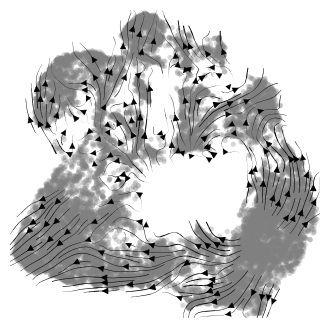

In [31]:
# visualize based on pseudotime and transition matrix
with plt.rc_context():
    pk.plot_projection(basis="umap", recompute=True, show=False)
    plt.savefig(out_dir +'pseudotime_transition.png')

In [32]:
# Save results
file_path = os.path.join(out_dir, "pseudotime_processed.h5ad")
adata.write(file_path)
# package versions
import pkg_resources
packagever = open(out_dir+"package_versions.txt", "w")
for package in pkg_resources.working_set:
    print(package.key, pkg_resources.get_distribution(package).version)
    packagever.write(package.key + " " + pkg_resources.get_distribution(package).version + "\n")
packagever.close()

fsspec 2023.9.2
xarray 2023.9.0
certifi 2023.7.22
pytz 2023.3.post1
tzdata 2023.3
tbb 2021.11.0
setuptools 65.5.1
pyzmq 25.1.1
pip 23.2.1
packaging 23.2
attrs 23.1.0
contextlib2 21.6.0
rich 13.6.0
nvidia-nvjitlink-cu12 12.3.101
nvidia-cuda-cupti-cu12 12.1.105
nvidia-cuda-nvrtc-cu12 12.1.105
nvidia-cuda-runtime-cu12 12.1.105
nvidia-nvtx-cu12 12.1.105
nvidia-cublas-cu12 12.1.3.1
nvidia-cusparse-cu12 12.1.0.106
nvidia-cusolver-cu12 11.4.5.107
websockets 11.0.3
nvidia-cufft-cu12 11.0.2.54
nvidia-curand-cu12 10.3.2.106
pillow 10.0.1
ipython 8.16.1
nvidia-cudnn-cu12 8.9.2.26
natsort 8.4.0
jupyter-client 8.4.0
click 8.1.7
ipykernel 6.25.2
deepdiff 6.6.0
tornado 6.3.3
importlib-resources 6.1.0
multidict 6.0.4
pyyaml 6.0.1
traitlets 5.11.2
psutil 5.9.5
jupyter-core 5.4.0
decorator 5.1.1
tzlocal 5.1
tqdm 4.66.1
fonttools 4.43.1
protobuf 4.24.4
beautifulsoup4 4.12.2
typing-extensions 4.8.0
pexpect 4.8.0
gdown 4.7.1
progressbar2 4.2.0
ordered-set 4.1.0
readchar 4.0.5
async-timeout 4.0.3
cmake 3.27